In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import json

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from bcnf.models.cnf import CondRealNVP
from bcnf.utils import get_dir
from bcnf.simulation.resimulation import resimulate
from bcnf.utils import load_config, load_data, sub_root_path

## Model

In [3]:
MODEL_NAME = f'trajectory_TRF_large'

In [4]:
with open(os.path.join(get_dir('models', 'bcnf-models', MODEL_NAME), 'config.json'), 'r') as f:
    config = load_config(json.load(f)['config_path'])

cnf = CondRealNVP.from_config(config).to(device)

cnf.load_state_dict(torch.load(os.path.join(get_dir('models', 'bcnf-models', MODEL_NAME), "state_dict.pt")))

cnf.eval();

In [5]:
print(f'Number of parameters: {cnf.n_params:,}')

Number of parameters: 48,808,039


In [6]:
parameter_selection = cnf.parameter_index_mapping.parameters

## Data

In [7]:
T = 2
dt = 1/15

In [8]:
data = load_data(sub_root_path(config['data']['path']).replace('/train', '/test'), verbose=True, keep_output_type='trajectories')

Loading data from directory: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it, file=fixed_data_render_2s_15FPS_5.pkl]


In [9]:
X_list = data['trajectories']

In [10]:
X = np.array(X_list)
y = cnf.parameter_index_mapping.vectorize(data)

print(f'{X.shape=}')
print(f'{y.shape=}')

X.shape=(1000, 30, 3)
y.shape=(1000, 19)


In [11]:
STEPS = X.shape[1]
d = X.shape[2]

print(f'{STEPS=}')
print(f'{d=}')

STEPS=30
d=3


In [12]:
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

print(f'{X_tensor.shape=}')
print(f'{y_tensor.shape=}')

X_tensor.shape=torch.Size([1000, 30, 3])
y_tensor.shape=torch.Size([1000, 19])


## Resimulation

In [13]:
data['g_z'] = data.pop('g')
data['g_x'] = np.zeros_like(data['g_z'])
data['g_y'] = np.zeros_like(data['g_z'])

In [14]:
# https://github.com/scipy/scipy/issues/15940
X_resimulation = resimulate(
    model=cnf,
    T=T,
    dt=dt,
    y_hat=None,
    data_dict=data,
    X=X_tensor,
    m_samples=1_000,
    batch_size=64,
    break_on_impact=True
)

Resimulating trajectories: 100%|██████████| 1000/1000 [03:55<00:00,  4.25it/s]


In [15]:
X_resimulation.shape

(1000, 1000, 30, 3)

In [16]:
X.shape

(1000, 30, 3)

## Resimulation Error

In [17]:
X_error = (X_resimulation - X[:, None, :, :])**2

/tmp/ipykernel_32172/2863506725.py:1: RuntimeWarning: overflow encountered in square
  X_error = (X_resimulation - X[:, None, :, :])**2


In [18]:
X_errors = np.nanmedian(X_error, axis=(1, 3))

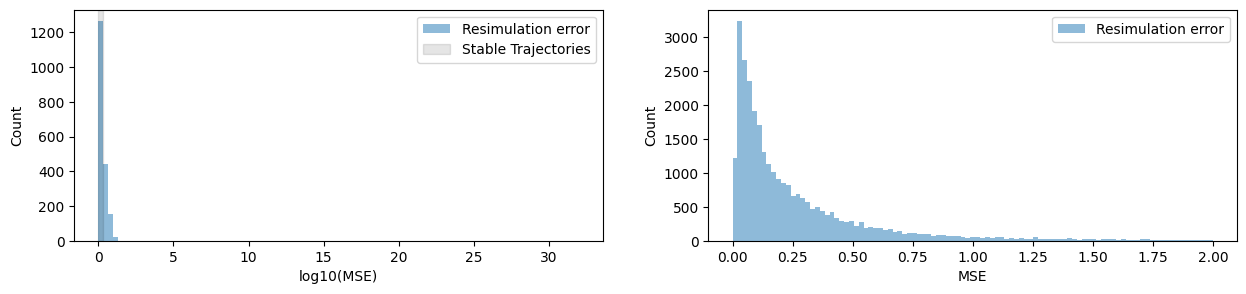

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

zoom_until = 2

axes[0].hist(np.log10(X_errors.flatten()), bins=np.linspace(0, 32, 100), alpha=0.5, label='Resimulation error');
axes[0].axvspan(0, np.log10(zoom_until), alpha=0.1, color='k', label='Stable Trajectories')

axes[0].set_xlabel('log10(MSE)')
axes[0].set_ylabel('Count')

axes[0].legend()

axes[1].hist(X_errors.flatten(), bins=np.linspace(0, zoom_until, 100), alpha=0.5, label='Resimulation error');

axes[1].set_xlabel('MSE')
axes[1].set_ylabel('Count')

axes[1].legend()

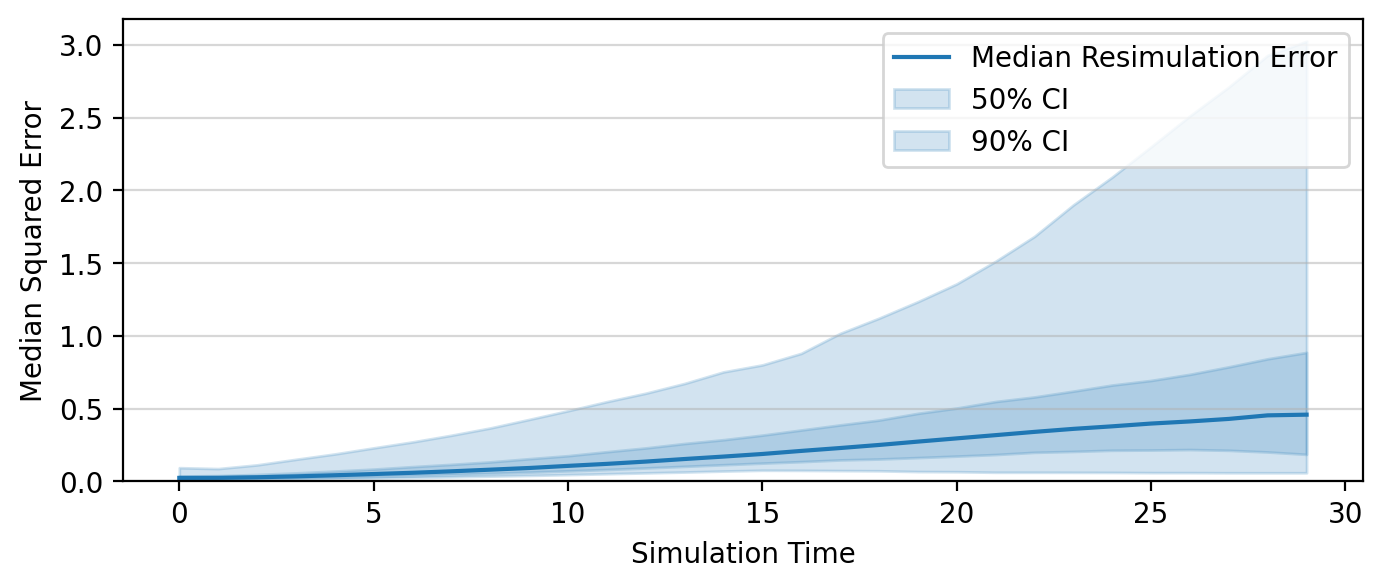

In [20]:
# Show the median resimulation error over simulation time
fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=200)

ax.plot(np.nanmedian(X_errors, axis=0), label='Median Resimulation Error')
ax.fill_between(np.arange(STEPS), *np.nanpercentile(X_errors, [25, 75], axis=0), alpha=0.2, color='C0', label='50% CI')
ax.fill_between(np.arange(STEPS), *np.nanpercentile(X_errors, [5, 95], axis=0), alpha=0.2, color='C0', label='90% CI')
ax.set_ylim(0, None)

ax.set_xlabel('Simulation Time')
ax.set_ylabel('Median Squared Error')
ax.legend()
ax.grid(axis='y', alpha=0.5)

plt.savefig(os.path.join(get_dir('results', f'{MODEL_NAME}', 'figures', create=True), 'resimulation_error.png'), bbox_inches='tight')

## Impact

In [21]:
# For each simulation i, find the indices j (sample), t (timestep), k in [i, j, t, -1] where X_resimulation changes sign from positive to negative
impact_indices = [np.where(np.diff((X_resimulation[i, :, :, -1] > 0).astype(int), axis=1) == -1) for i in range(X_resimulation.shape[0])]

# Get the potitions at the impact indices for each simulation i and sample j at time t
X_resimulation_impact_positions = [X_resimulation[i, impact_indices[i][0], impact_indices[i][1], :] for i in range(X_resimulation.shape[0])]

In [22]:
true_impact_indices = np.where(np.diff((X[:, :, -1] > 0).astype(int)) == -1)

X_val_impact_positions = X[true_impact_indices[0], true_impact_indices[1]]

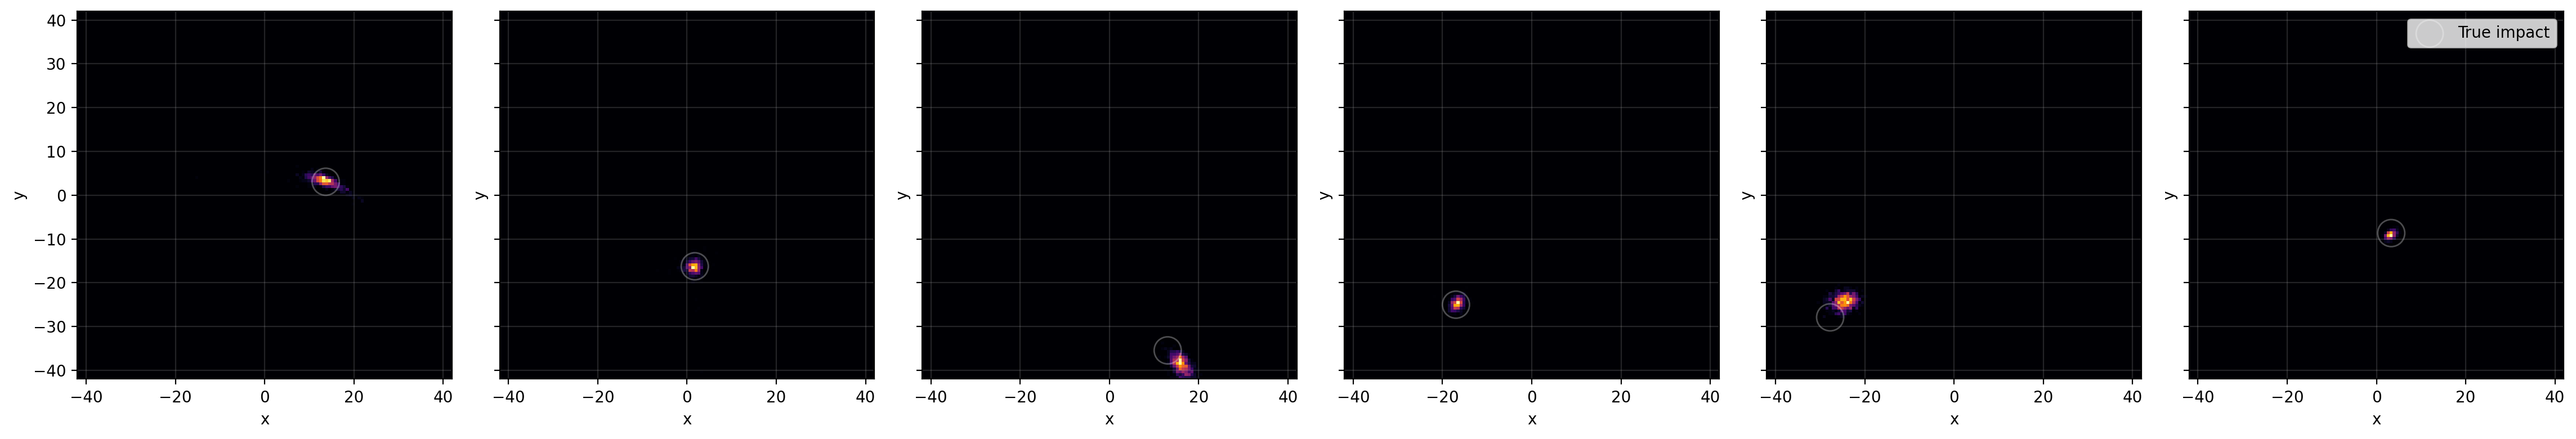

In [23]:
# Plot a heatmap of X_resimulation[0, impact_indices, :2]
fig, axes = plt.subplots(1, 6, figsize=(23, 4), sharey=True, dpi=200)

for i, (show_index, ax) in enumerate(zip(true_impact_indices[0], axes)):
    X_val_impact_position = X[show_index, true_impact_indices[1][np.where(true_impact_indices[0] == show_index)[0]][0], :]

    ax.hist2d(X_resimulation_impact_positions[show_index][:, 0], X_resimulation_impact_positions[show_index][:, 1], bins=np.linspace(-42, 42, 128), cmap='inferno');
    ax.scatter(X_val_impact_position[0], X_val_impact_position[1], s=300, marker='o', label='True impact', facecolors='none', edgecolors='white', alpha=0.3);
    ax.grid(axis='both', alpha=0.2);
    ax.set_xlabel('x');
    ax.set_ylabel('y');

ax.legend();

fig.tight_layout()

plt.savefig(os.path.join(get_dir('results', f'{MODEL_NAME}', 'figures', create=True), 'resimulation_impact_heatmap.png'))

## Resimulations

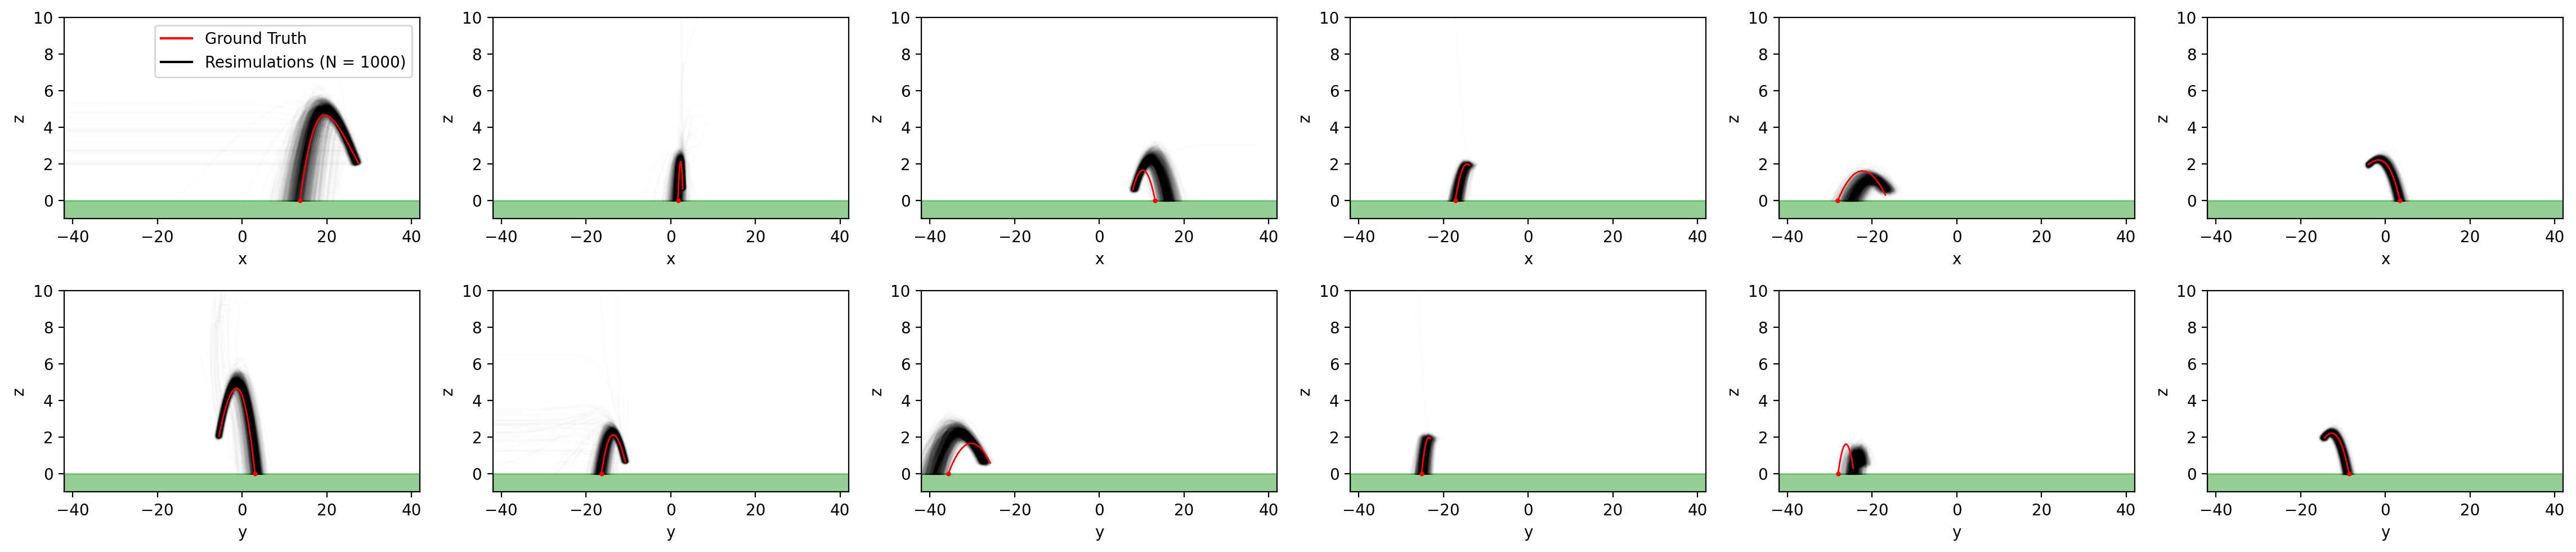

In [24]:
fig, axes = plt.subplots(2, 6, figsize=(23, 5), dpi=200)

n_trajectories = 1000
max_time = 1000

for i, (ax_row, ax_name) in enumerate(zip(axes, ['x', 'y'])):
    for show_index, ax in zip(true_impact_indices[0], ax_row):
        ax.plot(X_resimulation[show_index, :n_trajectories, :max_time, i].T, X_resimulation[show_index, :n_trajectories, :max_time, 2].T, alpha=0.01, color='black');
        ax.plot(X[show_index, :, i], X[show_index, :, 2], label='Ground Truth', color='red', linewidth=1);
        ax.plot(X[show_index, -1, i], X[show_index, -1, 2], marker='o', markersize=2, color='red');
        ax.set_xlim(-42, 42)
        ax.set_ylim(-1, 10)
        ax.set_xlabel(ax_name);
        ax.set_ylabel('z');
        ax.axhspan(-2, 0, alpha=0.5, color='tab:green');


# Add an additional legend for resimulation with red and black lines
red_patch = plt.Line2D([0], [0], color='red', label='Ground Truth')
black_patch = plt.Line2D([0], [0], color='black', label=f'Resimulations (N = {n_trajectories})')
axes[0, 0].legend(handles=[red_patch, black_patch], loc='upper right');

fig.tight_layout()

plt.savefig(os.path.join(get_dir('results', f'{MODEL_NAME}', 'figures', create=True), 'resimulation.png'), dpi=200)